https://www.kaggle.com/competitions/ml2022spring-hw1/

In [86]:
import torch
from torch import nn 
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import os
import math
from d2l import torch as d2l
import csv

In [87]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 570124,      # Your seed number, you can pick your lucky number. :)
    'select_all': True,   # Whether to use all features.
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 200,     # Number of epochs.            
    'batch_size': 256, 
    'learning_rate': 1e-3,
    'weight_decay': 0,
    'early_stop': 400,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/model.ckpt'  # Your model will be saved here.
}

# Data

In [88]:
train_data = pd.read_csv('./data/covid.train.csv').values
test_data = pd.read_csv('./data/covid.test.csv').values

In [89]:
class COVID19Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

In [90]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return torch.tensor(train_set, dtype=torch.float32), torch.tensor(valid_set, dtype=torch.float32)

In [91]:
same_seed(config['seed'])
train_data, valid_data = train_valid_split(train_data, config['valid_ratio'], config['seed'])
y_train, y_valid = train_data[:,-1], valid_data[:,-1]
x_train, x_valid, x_test = train_data[:,1:-1], valid_data[:,1:-1], test_data[:,1:]

train_dataset, valid_dataset, test_dataset = COVID19Dataset(x_train, y_train), COVID19Dataset(x_valid, y_valid), COVID19Dataset(x_test)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

# Model

In [92]:
class My_Model(nn.Module):
    def __init__(self, input_dim):
        super(My_Model, self).__init__()
        # TODO: modify model's structure, be aware of dimensions. 
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x

# Train

In [93]:
loss = nn.MSELoss()

In [94]:
def log_rmse(net, features, labels): 
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [95]:
x_train, y_train, x_valid, y_valid = x_train.to(device), y_train.to(device), x_valid.to(device), y_valid.to(device)

def train(net):
    if not os.path.isdir('./models'):
        os.mkdir('./models')
    train_ls, valid_ls = [], []
    optimizer = torch.optim.Adam(net.parameters(), lr = config['learning_rate'], weight_decay = config['weight_decay'])
    best_loss, step, early_stop_count = math.inf, 0, 0
    for epoch in range(config['n_epochs']):
        net.train()
        for X, y in train_loader:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, x_train, y_train))
        valid_ls.append(log_rmse(net, x_valid, y_valid))
        
        if valid_ls[-1] < best_loss:
            best_loss = valid_ls[-1]
            torch.save(net.state_dict(), config['save_path']) # Save your best model
            early_stop_count = 0
        else:
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return train_ls, valid_ls
    return train_ls, valid_ls

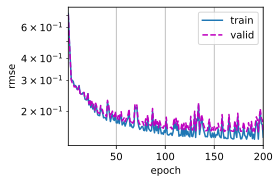

In [96]:
net = My_Model(input_dim=x_train.shape[1]).to(device)
train_ls, valid_ls = train(net)
d2l.plot(list(range(1, config['n_epochs'] + 1)), [train_ls, valid_ls], xlabel='epoch', ylabel='rmse', xlim=[1, config['n_epochs']], legend=['train', 'valid'], yscale='log')

# Predict

In [97]:
def predict(model):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in test_loader:
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)                     
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()  
    return preds
    
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

model = My_Model(input_dim=x_train.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(model) 
save_pred(preds, 'pred.csv')